In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from array import array
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar
from gridVarQ2Plot import col_dic
from analysis_utilities import drawOnCMSCanvas
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_pi = 0.13957
m_K = 0.49368
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

mD* - mD0 = 0.14543


In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [5]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

# Load data

In [6]:
loc = '../data/cmsRD/'
loc += 'ParkingBPH*/'
loc += 'Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbe_B2DstPi_200412_CAND.root'

tData = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tData.Add(floc)

print 'N evts: {:.0f}'.format(tData.GetEntries())

N evts: 430605


In [7]:
# loc = '../data/cmsMC_private/'
# loc += 'BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3'
# loc += '/ntuples_B2DstMu/out_CAND_*.root'

# tMu = rt.TChain('outA/Tevts')
# for floc in glob(loc):
#     tMu.Add(floc)

# print 'N evts: {:.0f}'.format(tMu.GetEntries())

In [8]:
def addOverflow(hh):
    Nbins = hh.GetNbinsX()
    hh.SetBinContent(Nbins, hh.GetBinContent(Nbins) + hh.GetBinContent(Nbins+1))
    hh.SetBinContent(Nbins+1, 0)
    return

In [39]:
def appendNewHisto(var, h_list, cuts, addCuts, leg=None, overflow=True):
    lastName = h_list[-1].GetName()
    if lastName == 'h':
        N =1
    else:
        N = 1 + int(lastName[1:])
        
    hAux = create_TH1D(np.zeros(0), name='h'+str(N), binning=h_list[0].binning)
    tData.Project('h'+str(N), var, cuts + ' && ' + addCuts)
    hAux.SetLineColor(col_dic.values()[N-1])
    hAux.Sumw2()
    if overflow:
        addOverflow(hAux)
    hAux.SetLineWidth(2)
    h_list.append(hAux)
    
    if not leg is None:
        leg.AddEntry(hAux, addCuts, 'lep')
    
    return h_list

# Cuts declaration

In [10]:
cut_general = [
    'n_B == 1',
#     'trgMu_pt > 12.1',
#     'trgMu_sigdxy > 7',
#     'abs(trgMu_eta) < 1.5',
]

$D_0$ reconstruction

In [11]:
cut_piK = [
'K_pt > 0.8',
'pi_pt > 0.8',
'pval_piK > 0.1',
'abs(K_eta) < 2.4',
'abs(pi_eta) < 2.4',
'abs(mass_piK - 1.864) < 0.05',
]

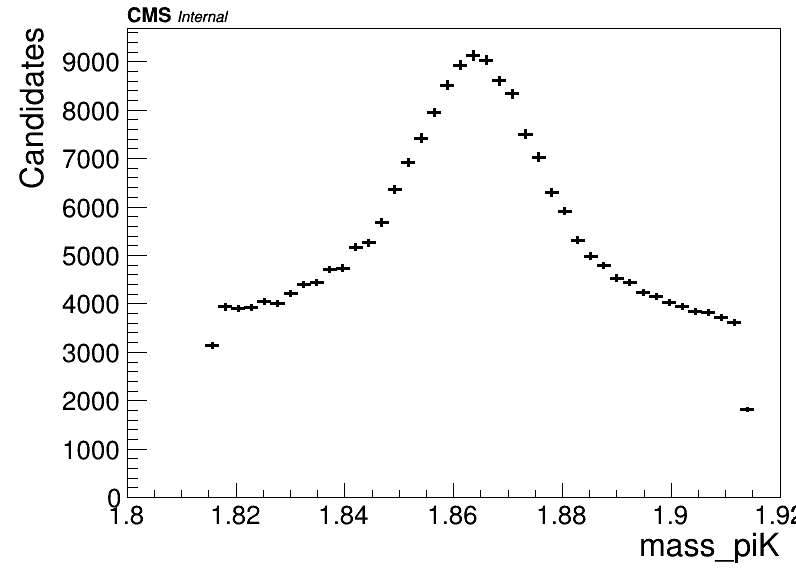

In [12]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass_piK', 'Candidates'],
                binning=[50, 1.8, 1.92] )
tData.Project('h', 'mass_piK', cuts)
h.Sumw2()
addOverflow(h)
# h.Scale(1./h.Integral())
h.SetLineWidth(3)
h_list=[h]

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')

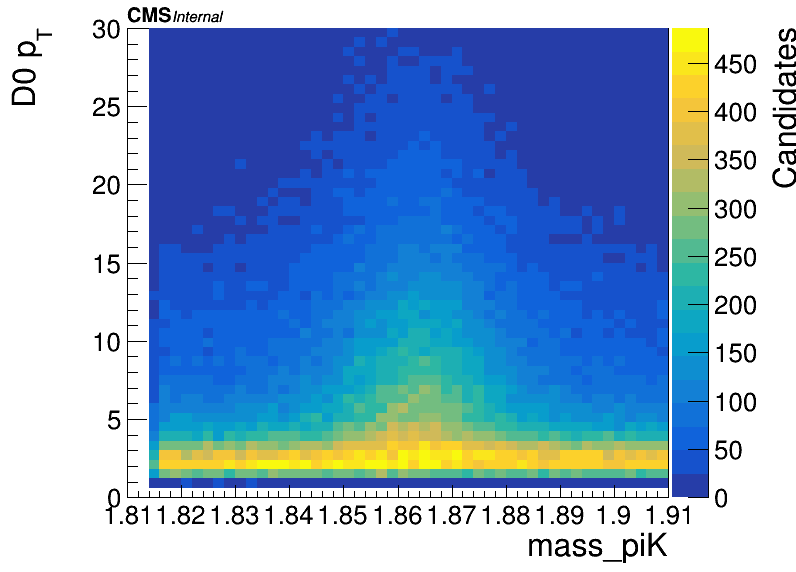

In [13]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass_piK', 'D0 p_{T}', 'Candidates'],
                binning=[50, 1.81, 1.91, 50, 0., 30.] )
tData.Project('h', 'D0_pt:mass_piK', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

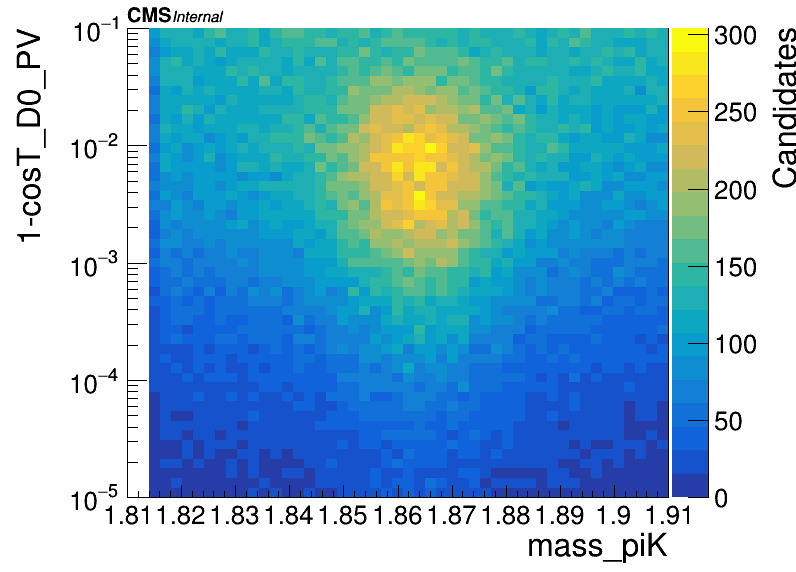

In [14]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass_piK', '1-cosT_D0_PV', 'Candidates'],
                binning=[np.linspace(1.81, 1.91, 50), np.logspace(-5, -1, 50)] )
tData.Project('h', '1 - cosT_D0_PV:mass_piK', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()

<ROOT.TLine object ("TLine") at 0xa7f80d0>

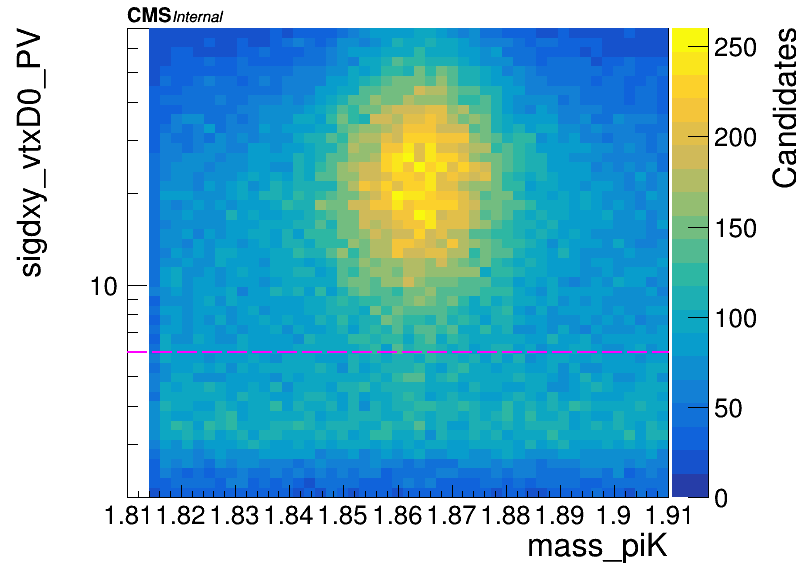

In [15]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass_piK', 'sigdxy_vtxD0_PV', 'Candidates'],
                binning=[np.linspace(1.81, 1.91, 50), np.logspace(np.log10(2), np.log10(70), 50)] )
tData.Project('h', 'sigdxy_vtxD0_PV:mass_piK', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()
cl.DrawLine(1.81, 6, 1.91, 6)

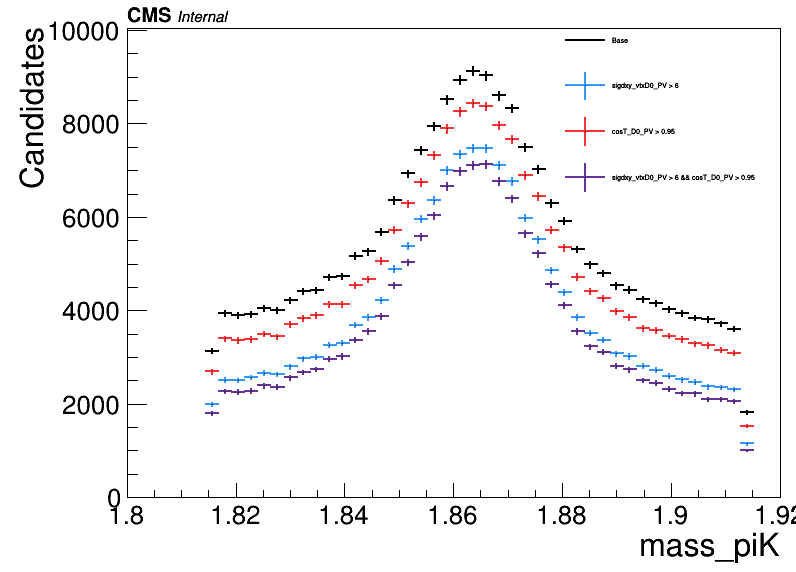

In [16]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass_piK', 'Candidates'],
                binning=[50, 1.8, 1.92] )
tData.Project('h', 'mass_piK', cuts)
h.Sumw2()
addOverflow(h)
h.SetLineWidth(2)
h_list=[h]

leg = rt.TLegend(0.7, 0.65, 0.98, 0.97)
leg.AddEntry(h, 'Base', 'l')
leg.SetTextFont(42)
leg.SetFillStyle(0)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

appendNewHisto('mass_piK', h_list, cuts, 'sigdxy_vtxD0_PV > 6', leg=leg)
appendNewHisto('mass_piK', h_list, cuts, 'cosT_D0_PV > 0.95', leg=leg)
appendNewHisto('mass_piK', h_list, cuts, 'sigdxy_vtxD0_PV > 6 && cosT_D0_PV > 0.95', leg=leg)

SetMaxToMaxHist(h_list)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()

In [17]:
cut_piK_rev = [
'K_pt > 0.8',
'pi_pt > 0.8',
'pval_piK > 0.1',
'abs(K_eta) < 2.4',
'abs(pi_eta) < 2.4',
'abs(mass_piK - {}) < 0.035'.format(m_D0),
'sigdxy_vtxD0_PV > 6',
'cosT_D0_PV > 0.95'
]

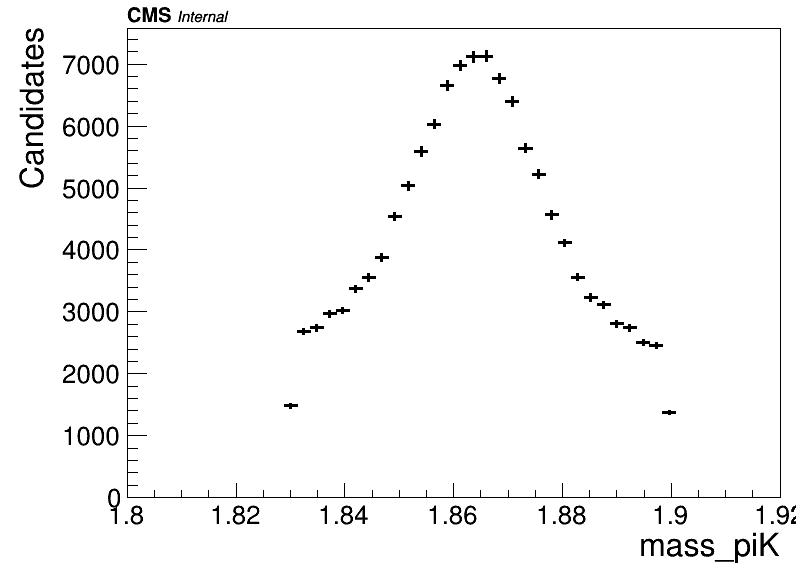

In [18]:
cuts = ' && '.join(cut_general+cut_piK_rev)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass_piK', 'Candidates'],
                binning=[50, 1.8, 1.92] )
tData.Project('h', 'mass_piK', cuts)
h.Sumw2()
h.SetLineWidth(3)
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

# $D^*$ Recostruction

In [19]:
cut_D0pih = [
# 'pih_pt > 0.4',
'abs(pih_eta) < 2.4',
'pval_D0pih > 0.1',
]

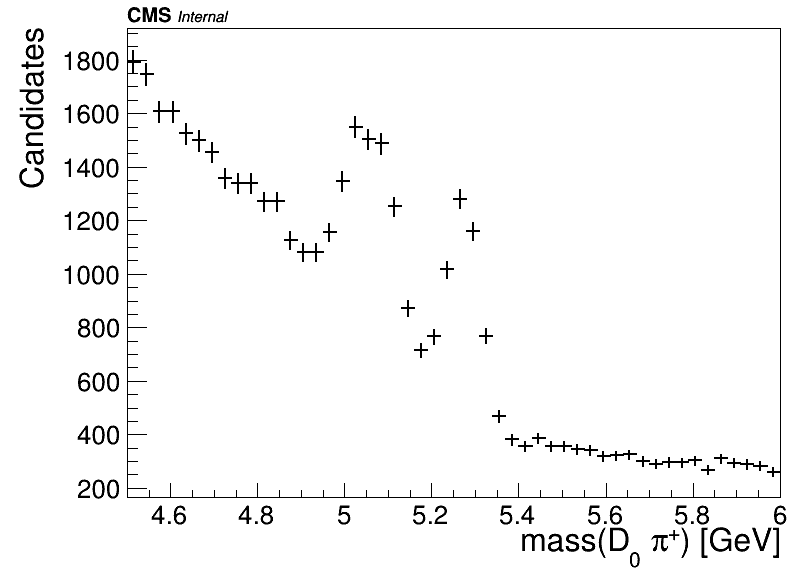

In [20]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pih)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0} #pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 4.5, 6] )
tData.Project('h', 'mass_D0pih', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

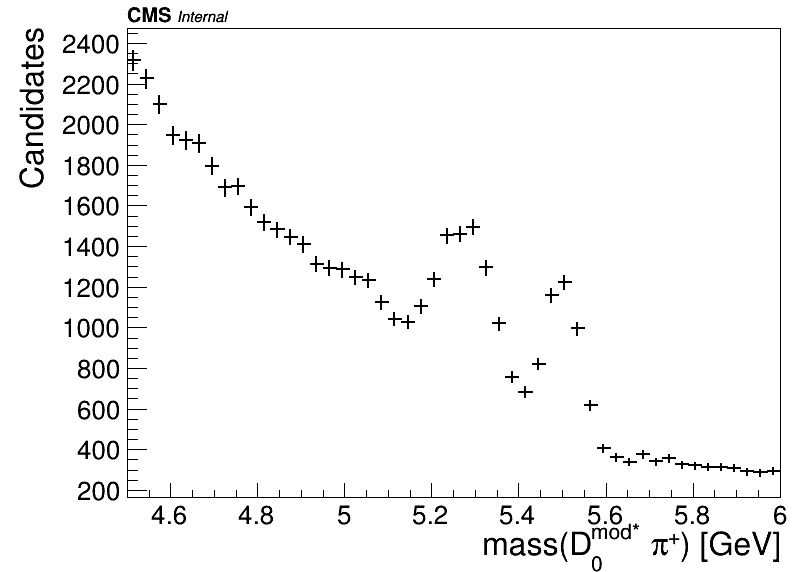

In [21]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pih)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}^{mod*} #pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 4.5, 6] )
tData.Project('h', 'mass_D0pih_scaledDst', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

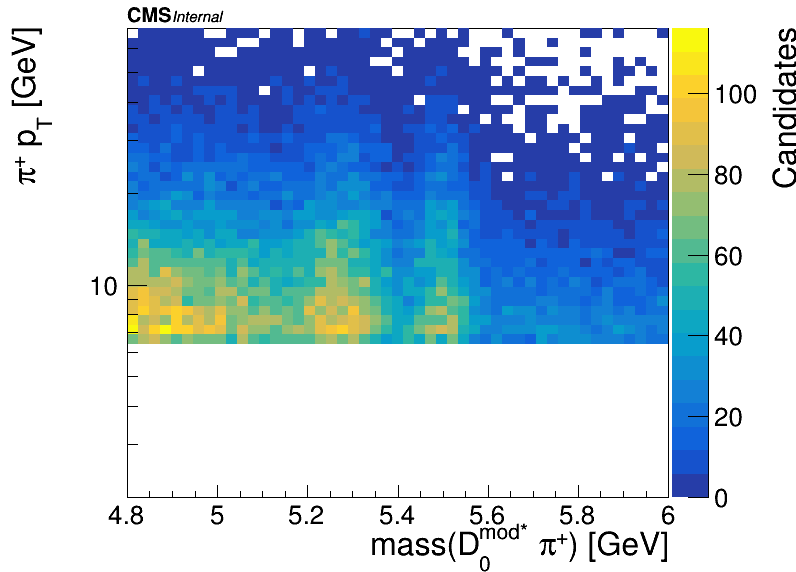

In [32]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pih)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass(D_{0}^{mod*} #pi^{+}) [GeV]', '#pi^{+} p_{T} [GeV]', 'Candidates'],
                binning=[np.linspace(4.8, 6, 50), np.logspace(np.log10(2), np.log10(70), 50)] )
tData.Project('h', 'pih_pt:mass_D0pih_scaledDst', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()

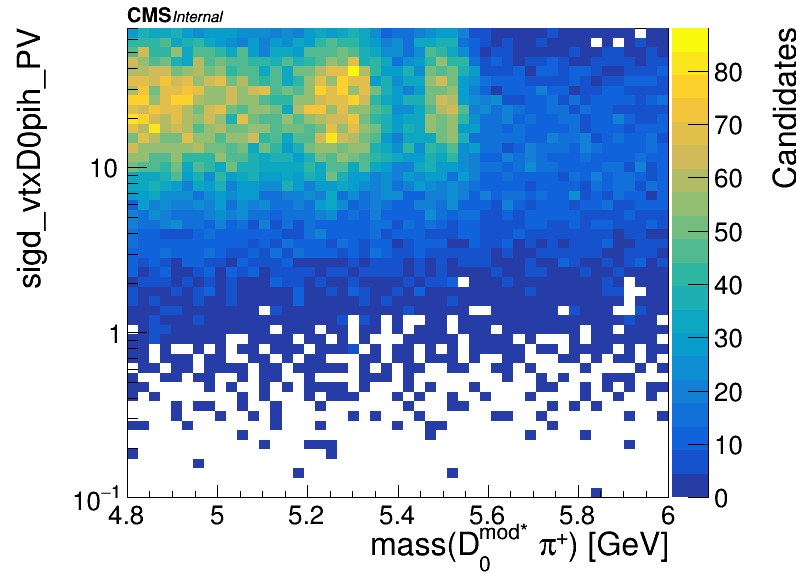

In [33]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pih)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass(D_{0}^{mod*} #pi^{+}) [GeV]', 'sigd_vtxD0pih_PV', 'Candidates'],
                binning=[np.linspace(4.8, 6, 50), np.logspace(-1, np.log10(70), 50)] )
tData.Project('h', 'sigd_vtxD0pih_PV:mass_D0pih_scaledDst', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()

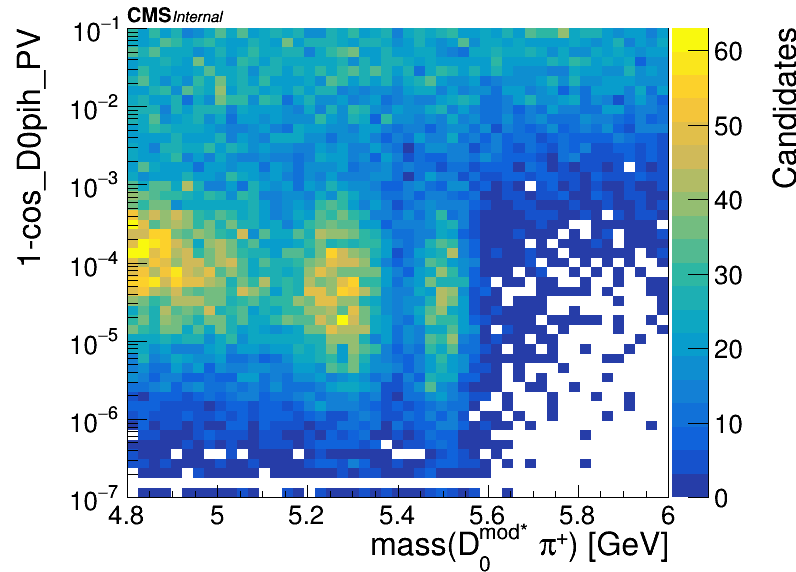

In [37]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pih)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass(D_{0}^{mod*} #pi^{+}) [GeV]', '1-cos_D0pih_PV', 'Candidates'],
                binning=[np.linspace(4.8, 6, 50), np.logspace(-7, -1, 50)] )
tData.Project('h', '1-cos_D0pih_PV:mass_D0pih_scaledDst', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()

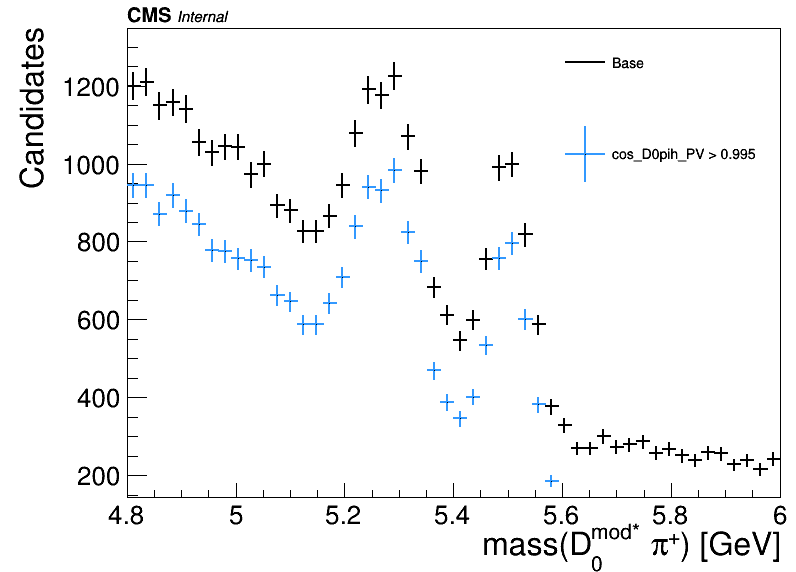

In [41]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pih)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}^{mod*} #pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 4.8, 6] )
tData.Project('h', 'mass_D0pih_scaledDst', cuts)
h.Sumw2()
h.SetLineWidth(2)
h_list=[h]

leg = rt.TLegend(0.7, 0.65, 0.98, 0.97)
leg.AddEntry(h, 'Base', 'l')
leg.SetTextFont(42)
leg.SetFillStyle(0)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

appendNewHisto('mass_D0pih_scaledDst', h_list, cuts, 'cos_D0pih_PV > 0.995', leg=leg, overflow=False)

SetMaxToMaxHist(h_list)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()

In [42]:
cut_D0pih_rev = [
# 'pih_pt > 0.4',
'abs(pih_eta) < 2.4',
'pval_D0pih > 0.1',
'cos_D0pih_PV > 0.995'
]

In [66]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pih_rev)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}^{mod*} #pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 4.5, 6] )
tData.Project('h', 'mass_D0pih_scaledDst', cuts)
h.Sumw2()

In [69]:
fBkg = rt.TF1('fBkg', 'pol3', 4.5, 6)
gBkg = rt.TGraphErrors()
for i in range(1,51):
    x = h.GetBinCenter(i)
    if x < 5.1 or x > 5.65:
        y = h.GetBinContent(i)
        gBkg.SetPoint(i-1, x, y)
        gBkg.SetPointError(i-1, 0, h.GetBinError(i))

gBkg.Fit(fBkg, 's')


****************************************
Minimizer is Linear
Chi2                      =      62.3532
NDf                       =           28
p0                        =     -16605.1   +/-   8072        
p1                        =      16685.3   +/-   4525.58     
p2                        =     -4231.79   +/-   842.542     
p3                        =      319.125   +/-   52.1102     


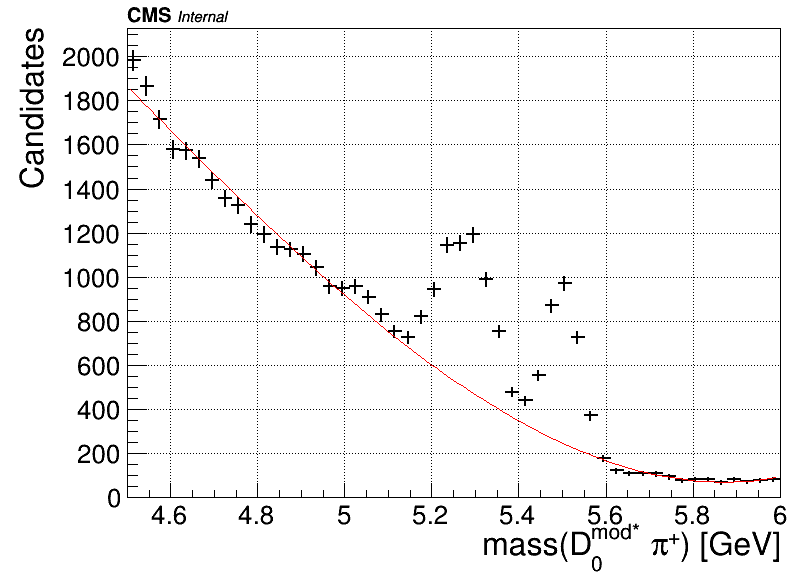

In [70]:
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetGrid()
fBkg.Draw('same')

In [72]:
nLow = 0
nHigh = 0
for i in range(1,51):
    x = h.GetBinCenter(i)
    if x > 5.1 and x < 5.65:
        y = h.GetBinContent(i)
        yf = fBkg.Eval(x)
        if x < 5.4:
            nLow += y - yf
        else:
            nHigh += y - yf
print nLow/nHigh        

1.51594326291


In [ ]:
raise

# Study on the additional tracks

In [ ]:
def drawPlot(var, addCut, binning, axis_title, logy=True, logx=False, addSel=''):
    h = create_TH1D(np.zeros(0), name='h',
                    title='', axis_title=axis_title,
                    binning=binning )
    tMu.Project('h', var, cut_str + addSel)
    h.Sumw2()
    addOverflow(h)
    h.Scale(1./h.Integral())
    h.SetLineColor(colors['mu'])
    h.SetLineWidth(3)
    N = tMu.GetEntries(cut_str + addSel)
    n = tMu.GetEntries(cut_str + addSel + addCut)
    print 'Mu: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

    h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
    tTau.Project('h3', var, cut_str + addSel)
    h3.Sumw2()
    addOverflow(h3)
    h3.Scale(1./h3.Integral())
    h3.SetLineColor(colors['tau'])
    h3.SetLineWidth(3)
    N = tTau.GetEntries(cut_str + addSel)
    n = tTau.GetEntries(cut_str + addSel + addCut)
    print 'Tau: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

    h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
    tDstst.Project('h2', var, cut_str + addSel)
    h2.Sumw2()
    addOverflow(h2)
    h2.Scale(1./h2.Integral())
    h2.SetLineColor(colors['Dstst'])
    h2.SetLineWidth(3)
    N = tDstst.GetEntries(cut_str + addSel)
    n = tDstst.GetEntries(cut_str + addSel + addCut)
    print 'Dstst: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

    h1 = create_TH1D(np.zeros(0), name='h1', binning=h.binning)
    tHc.Project('h1', var, cut_str + addSel)
    h1.Sumw2()
    addOverflow(h1)
    h1.Scale(1./h1.Integral())
    h1.SetLineColor(colors['Hc'])
    h1.SetLineWidth(3)
    N = tHc.GetEntries(cut_str + addSel)
    n = tHc.GetEntries(cut_str + addSel + addCut)
    print 'Hc: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

    leg = rt.TLegend(0.6, 0.55, 0.9, 0.94)
    leg.AddEntry(h, label_dic['mu'], 'l')
    leg.AddEntry(h3, label_dic['tau'], 'l')
    leg.AddEntry(h2, label_dic['Dstst'], 'l')
    leg.AddEntry(h1, label_dic['Hc'], 'l')
    leg.SetTextFont(42)
    leg.SetTextAlign(12)
    leg.SetLineWidth(0)
    leg.SetBorderSize(0)
    m = SetMaxToMaxHist([h, h1, h2, h3])
    c = drawOnCMSCanvas(CMS_lumi, [h, h1, h2, h3], 'same')
    if logy: 
        c.SetLogy()
    if logx: 
        c.SetLogx()
    leg.Draw()
    c.Draw()
    c.leg=leg
    return c, m

In [ ]:
c = drawPlot('nTksAdd', ' && nTksAdd == 0', 
         array('d', list(np.arange(-0.5, 3.5, 1)) + [5.5, 8.5] ), 
         ['Number of additional tracks', 'Normalized entries'], 
         logy=True)

In [ ]:
c, m = drawPlot('tksAdd_massHad', ' && tksAdd_massHad > 2.35 && tksAdd_massHad < 2.6', 
         [100, 2, 5], 
         ['Hadronic mass [GeV]', 'Normalized entries'], 
         logy=False)

cl.DrawLine(2.35, 0, 2.35, m)
cl.DrawLine(2.6, 0, 2.6, m)

In [ ]:
c, m = drawPlot('tksAdd_massVis', ' && tksAdd_massVis < {}'.format(m_B0), 
         [150, 2, 10], 
         ['Visible mass [GeV]', 'Normalized entries'], 
         logy=False)

cl.DrawLine(m_B0, 0, m_B0, m)

In [ ]:
c, m = drawPlot('1-tksAdd_cos_PV', ' && tksAdd_cos_PV > 0.95', 
         [200, 0, 2], 
         ['1 - Pointing cos', 'Normalized entries'], 
         logy=False,
         logx=False,
        )

cl.DrawLine(0.05, 0, 0.05, m)

In [ ]:
c, m = drawPlot('tksAdd_massMuTk', ' && tksAdd_massMuTk < 2', 
         [50, 0,10], 
         ['Mass (#mu tk)', 'Normalized entries'], 
         logy=False)

cl.DrawLine(2, 0, 2, m)

In [ ]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['Hadronic mass [GeV]', 'Visible mass [GeV]', 'Events'],
                binning=[np.linspace(2, 3.5, 30), np.linspace(2.5, 6.5, 30)]
               )
tMu.Project('h', 'tksAdd_massVis:tksAdd_massHad', cut_str)
h.Sumw2()

h2 = create_TH2D(np.zeros((2,2)), name='h2', binning=h.binning)
tDstst.Project('h2', 'tksAdd_massVis:tksAdd_massHad', cut_str)
h2.Sumw2()
h2.SetMarkerColor(rt.kRed)

h3 = create_TH2D(np.zeros((2,2)), name='h3', binning=h.binning)
tTau.Project('h3', 'tksAdd_massVis:tksAdd_massHad', cut_str)
h3.Sumw2()
h3.SetMarkerColor(rt.kBlue)
                         
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
# cl.DrawLine(1.76, 1.76+0.16, 1.91, 1.91+0.16)
# c.SetLogy()
c.Draw()

In [ ]:
c, m = drawPlot('Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95)'.format(m_B0), 
                ' && Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95) < 1'.format(m_B0), 
                [9, -0.5,8.5], 
                ['Additional low mass traks', 'Normalized entries']
               )

cl.DrawLine(0.5, 0, 0.5, m)

In [ ]:
c, m = drawPlot('tksAdd_massHad', ' && tksAdd_massHad > 2.35 && tksAdd_massHad < 2.6',
                addSel = ' && Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95) > 0'.format(m_B0), 
                binning=[100, 2, 5], 
                axis_title=['Hadronic mass in inverted selection [GeV]', 'Normalized entries'],
                logy=False)

cl.DrawLine(2.35, 0, 2.35, m)
cl.DrawLine(2.6, 0, 2.6, m)

In [ ]:
c, m = drawPlot('tksAdd_massMuTk', ' && tksAdd_massMuTk < 2',
                addSel = ' && Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95) > 0'.format(m_B0), 
                binning=[50, 0,10], 
                axis_title=['Mass (#mu tk) in inverted selection [GeV]', 'Normalized entries'],
                logy=False)

cl.DrawLine(2, 0, 2, m)

In [ ]:
# var = 'Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95)'.format(m_B0)
var = 'Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95 && tksAdd_massHad > 2.35 && tksAdd_massHad < 2.6)'.format(m_B0)

h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Number of additional tracks', 'Events'],
                binning=[12, -0.5, 11.5]
               )
tMu.Project('h', var, cut_str)
h.Sumw2()
h.Scale(1./h.Integral())
N = tMu.GetEntries(cut_str)
n = tMu.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Mu: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tTau.Project('h3', var, cut_str)
h3.Sumw2()
h3.Scale(1./h3.Integral())
h3.SetLineColor(rt.kBlue)
N = tTau.GetEntries(cut_str)
n = tTau.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Tau: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tDstst.Project('h2', var, cut_str)
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(rt.kRed)
N = tDstst.GetEntries(cut_str)
n = tDstst.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Dstst: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)


# h4 = create_TH1D(np.zeros(0), name='h4', binning=h.binning)
# tData.Project('h4', var, cut_str)
# h4.Sumw2()
# h4.Scale(1./h4.Integral())
# h4.SetLineColor(rt.kAzure)
# N = tData.GetEntries(cut_str)
# n = tData.GetEntries(cut_str + ' && {} >= 1'.format(var))
# print 'Data: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

leg = rt.TLegend(0.6, 0.5, 0.9, 0.9)
leg.AddEntry(h, label_dic['mu'], 'lep')
leg.AddEntry(h3, label_dic['tau'], 'lep')
leg.AddEntry(h2, label_dic['Dstst'], 'lep')
# leg.AddEntry(h4, label_dic['Data'], 'lep')
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
c.SetLogy()
leg.Draw()
c.Draw()

In [ ]:
sel = 'Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95) > 1'.format(m_B0)
# var = 'tksAdd_pval'
var= 'tksAdd_massHad'
# var= 'tksAdd_pt'

h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Hadronic Mass [GeV]', 'Events'],
                binning=[30, 2., 3.]
#                 axis_title=['pval', 'Events'],
#                 binning=[50, 0, 1.]
#                 axis_title=['pT [GeV]', 'Events'],
#                 binning=[50, 0, 5.]
               )
tMu.Project('h', var, cut_str + ' && ' + sel)
addOverflow(h)
h.Sumw2()
h.Scale(1./h.Integral())

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tTau.Project('h3', var, cut_str + ' && ' + sel)
addOverflow(h3)
h3.Sumw2()
h3.Scale(1./h3.Integral())
h3.SetLineColor(rt.kBlue)

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tDstst.Project('h2', var, cut_str + ' && ' + sel)
addOverflow(h2)
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(rt.kRed)


# h4 = create_TH1D(np.zeros(0), name='h4', binning=h.binning)
# tData.Project('h4', var, cut_str)
# h4.Sumw2()
# h4.Scale(1./h4.Integral())
# h4.SetLineColor(rt.kAzure)
# N = tData.GetEntries(cut_str)
# n = tData.GetEntries(cut_str + ' && {} >= 1'.format(var))
# print 'Data: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

leg = rt.TLegend(0.6, 0.5, 0.9, 0.9)
leg.AddEntry(h, label_dic['mu'], 'lep')
leg.AddEntry(h3, label_dic['tau'], 'lep')
leg.AddEntry(h2, label_dic['Dstst'], 'lep')
# leg.AddEntry(h4, label_dic['Data'], 'lep')
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
leg.Draw()
c.Draw()